### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from typing import List, Dict, Tuple
from tqdm import tqdm

### Dataset Class and Dataloader

In [2]:
# Set device to cuda
device = torch.device('cuda:0')

# Create dataset class
class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, num_vids=7, seq_length=5, img_size=256):
        """
        Go through each video folder and build a map from
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where
        j is the video number and k the frame index in that
        video. For reference, the videos are stored in the
        dataset as:

        data:
        - test1:
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ...
          - targets:
            - frame0000.png
            - frame0001.png
            - ...
        - test2:
            - ...
        - ...
        """
        self.img_size = img_size
        self.seq_length = seq_length
        self.augmented = augmented
        self.num_vids = num_vids
        self.path_to_data = path_to_data
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {}
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")

            # Get poses
            self.poses[i] = pd.read_csv(pose_path).to_numpy()
            self.twists[i] = pd.read_csv(twist_path).to_numpy()

            # Get number of sequences in this video: num_frames - (seq_length - 1)
            num_sequences = (self.poses[i].shape[0] - 1) - (self.seq_length - 1)

            # Update index map
            video_num = [i] * num_sequences
            frame_idx = list(range(0, num_sequences))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_sequences = len(self.idx_map)

    def __len__(self):
        """
        Return length of dataset as computed in __init__() function.
        """
        return self.total_num_sequences

    def __getitem__(self, idx):
        """
        Use map built in __init__() to retrieve the image,
        pose, and twist directly from the dataset.
        This avoids loading the entire dataset which
        overwhelms RAM.
        """
        assert idx < self.total_num_sequences
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq_start = True
        for i in range(self.seq_length):
            # Define path to data
            test_idx, frame_idx = self.idx_map[idx]
            frame_idx += i
            padded_frame_idx = self.to_zero_pad_idx(frame_idx)
            input_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
            output_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/targets/frame{padded_frame_idx}.png')

            # Debug:
            # print(f'\ntest idx, frame idx: {test_idx, frame_idx}')

            # Load and process data
            input_frame = io.imread(input_img_path)
            output_frame = io.imread(output_img_path)
            input_frame = torch.from_numpy(self.to_grayscale(input_frame)).float()
            output_frame = torch.from_numpy(self.to_grayscale(output_frame)).float()
            pose = self.poses[test_idx][frame_idx]
            pose = torch.from_numpy(self.pose_vector_from_matrix(pose).reshape(-1, 1)).float()
            twist = torch.from_numpy(self.twists[test_idx][frame_idx].reshape(-1, 1)).float()
            state = torch.cat((pose, twist), dim=0).view(-1)

            # Resize frames
            h, w = self.img_size, self.img_size
            resize_frame = transforms.Resize((h, w))
            output_frame = resize_frame(output_frame.unsqueeze(0))
            input_frame = resize_frame(input_frame.unsqueeze(0))

            if not self.augmented:
                # Initialize sequence
                if seq_start:
                    in_frame_seq = torch.zeros_like(input_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    out_frame_seq = torch.zeros_like(output_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    state_seq = torch.zeros_like(state).unsqueeze(0).repeat((self.seq_length, 1))
                    seq_start = False

                # Update sequence
                in_frame_seq[i] = input_frame.view(1, h, w)
                out_frame_seq[i] = output_frame.view(1, h, w)
                state_seq[i] = state

            # If we want a broadcasted frame, pose, twist tensor of shape (B, T, 1, H, W, 14)
            else:
                expanded_frame = input_frame.view(1, h, w, 1)
                expanded_state = state.view(1, 1, 1, -1).repeat(1, h, w, 1)
                augmented_frame = torch.cat((expanded_frame, expanded_state), dim=-1)

                # Initialize augmented sequence
                if seq_start:
                    aug_seq_in = torch.zeros_like(augmented_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1, 1))
                    aug_seq_out = torch.zeros_like(output_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1))
                    seq_start = False

                # Update augmented sequence
                aug_seq_in[i] = augmented_frame
                aug_seq_out[i] = output_frame

        return {'input': (in_frame_seq, state_seq), 'target': out_frame_seq} if not self.augmented else {'input': aug_seq_in, 'target': aug_seq_out}

    def to_zero_pad_idx(self, idx):
        """
        Convert frame index from regular index to zero-padded index.
        e.g. 1 -> 00001, 12 -> 00012
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose):
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
        """
        pose = pose.reshape(4, 4)
        position = pose[:3, 3].reshape(3, 1)
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1)
        norm_quat = quat / np.linalg.norm(quat)

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """
        Convert PNG image to grayscale mask
        """
        #TODO: Try float16 type
        return (image[..., 0] > 127).astype(np.float32)


In [3]:

import torch.nn.functional as F

# Utility function to safely reshape even with empty batch
def safe_view(tensor, shape):
    if 0 in shape:
        return torch.zeros(shape, device=tensor.device, dtype=tensor.dtype)
    return tensor.view(*shape)

class PoseEncoder(nn.Module):
    def __init__(self, pose_dim=13, hidden_dim=64, output_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(pose_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.output_dim = output_dim

    def forward(self, pose):
        B, T, _ = pose.shape
        if B == 0 or T == 0:
            return torch.zeros((B, T, self.output_dim), device=pose.device, dtype=pose.dtype)
        pose_flat = pose.view(B * T, -1)
        features = self.encoder(pose_flat)
        return features.view(B, T, -1)

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv2 = nn.Conv2d(in_channels // 8, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = F.relu(self.conv1(x))
        attention = self.sigmoid(self.conv2(attention))
        return x * attention

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3, 3), stride=1, padding=1):
        super().__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.spatial_attention = SpatialAttention(out_channels)

    def forward(self, x):
        x = self.relu(self.bn(self.conv3d(x)))
        B, C, T, H, W = x.shape
        if B == 0 or T == 0:
            return torch.zeros((B, C, T, H, W), device=x.device, dtype=x.dtype)
        x_reshaped = x.permute(0, 2, 1, 3, 4).contiguous().view(B * T, C, H, W)
        x_attended = self.spatial_attention(x_reshaped)
        x = safe_view(x_attended, (B, T, C, H, W)).permute(0, 2, 1, 3, 4)
        return x

class PoseGuidedFusion(nn.Module):
    def __init__(self, visual_channels, pose_features, output_channels):
        super().__init__()
        self.pose_proj = nn.Linear(pose_features, visual_channels)
        self.fusion_conv = nn.Conv2d(visual_channels * 2, output_channels, 1)
        self.out_channels = output_channels

    def forward(self, visual_features, pose_features):
        B, C, T, H, W = visual_features.shape
        if B == 0 or T == 0:
            return torch.zeros((B, self.out_channels, T, H, W), device=visual_features.device, dtype=visual_features.dtype)
        pose_proj = self.pose_proj(pose_features).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, H, W)
        visual_flat = visual_features.permute(0, 2, 1, 3, 4).contiguous().view(B * T, C, H, W)
        pose_flat = pose_proj.contiguous().view(B * T, C, H, W)
        fused = torch.cat([visual_flat, pose_flat], dim=1)
        output = self.fusion_conv(fused)
        output = safe_view(output, (B, T, -1, H, W)).permute(0, 2, 1, 3, 4)
        return output

class FilterNet(nn.Module):
    def __init__(self, input_shape=(256, 256), pose_dim=13, hidden_channels=64):
        super().__init__()
        self.input_shape = input_shape
        self.pose_dim = pose_dim
        self.hidden_channels = hidden_channels

        self.pose_encoder = PoseEncoder(pose_dim, 64, 128)
        self.encoder1 = TemporalBlock(1, hidden_channels)
        self.encoder2 = TemporalBlock(hidden_channels, hidden_channels * 2)
        self.encoder3 = TemporalBlock(hidden_channels * 2, hidden_channels * 4)
        self.pose_fusion = PoseGuidedFusion(hidden_channels * 4, 128, hidden_channels * 4)
        self.bottleneck = TemporalBlock(hidden_channels * 4, hidden_channels * 8)
        self.decoder3 = TemporalBlock(hidden_channels * 8 + hidden_channels * 4, hidden_channels * 4)
        self.decoder2 = TemporalBlock(hidden_channels * 4 + hidden_channels * 2, hidden_channels * 2)
        self.decoder1 = TemporalBlock(hidden_channels * 2 + hidden_channels, hidden_channels)
        self.output_conv = nn.Conv3d(hidden_channels, 1, kernel_size=(1, 1, 1))
        self.sigmoid = nn.Sigmoid()
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

    def forward(self, video_masks, pose_info):
        B, T, C, H, W = video_masks.shape
        if B == 0 or T == 0:
            return torch.zeros((B, T, 1, H, W), device=video_masks.device, dtype=video_masks.dtype)

        x = video_masks.permute(0, 2, 1, 3, 4)
        pose_features = self.pose_encoder(pose_info)

        enc1 = self.encoder1(x)
        x_pool1 = self.pool(enc1)
        enc2 = self.encoder2(x_pool1)
        x_pool2 = self.pool(enc2)
        enc3 = self.encoder3(x_pool2)
        x_pool3 = self.pool(enc3)

        enc3_fused = self.pose_fusion(enc3, pose_features)
        bottleneck = self.bottleneck(x_pool3)

        up3 = F.interpolate(bottleneck, size=(T, H // 4, W // 4), mode='trilinear', align_corners=False)
        dec3 = torch.cat([up3, enc3_fused], dim=1)
        dec3 = self.decoder3(dec3)

        up2 = F.interpolate(dec3, size=(T, H // 2, W // 2), mode='trilinear', align_corners=False)
        dec2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.decoder2(dec2)

        up1 = F.interpolate(dec2, size=(T, H, W), mode='trilinear', align_corners=False)
        dec1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.decoder1(dec1)

        output = self.output_conv(dec1)
        output = self.sigmoid(output)
        output = output.permute(0, 2, 1, 3, 4)
        return output

    def loss(self, sequence):
        frames, state = sequence['input']
        target = sequence['target']
        B = frames.shape[0]
        if B == 0:
            return torch.tensor(0.0, device=frames.device, requires_grad=True), torch.zeros_like(target)

        pred = self.forward(frames, state)
        target = torch.clamp(target, 0, 1)

        bce_loss = F.binary_cross_entropy(pred, target)
        intersection = (pred * target).sum()
        dice_loss = 1 - (2 * intersection + 1) / (pred.sum() + target.sum() + 1)
        temporal_diff = torch.abs(pred[:, 1:] - pred[:, :-1])
        temporal_loss = temporal_diff.mean()

        total_loss = bce_loss + 0.5 * dice_loss + 0.1 * temporal_loss
        return total_loss, pred


### Submodules

Here are the Encoders, Decoder, and LSTM

In [5]:
# Write classes for compression networks

#TODO: Try a conv3d encoder. conv3d layers encode temporal information. (Alternative to LSTM). An alternative to the current pipeline would
# be to use the augmented data tensor (without compressing it) and a conv3d layer to process the (T, B, 1, H, W, 14) input. Which would need to be
#reshaped to (B, 1, T, H, W, 14). I wouldn't know what to do with the state dimension. Treat them as channels (image, pose, twist)? Flatten them with the sequence dim?

class ImgEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        return self.conv_stack(x[-1])

class ImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a SEQUENCE of 256 x 256 images into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        seq_len, batch_size, _, h, w = x.shape
        x = x.reshape(seq_len * batch_size, 1, h, w)
        return self.conv_stack(x).reshape(seq_len, batch_size, -1)

class StateEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        Input has shape (T, B, D) need (B, D)
        """
        return self.linear_layer(x[-1])

class StateSeqEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a sequence of length 128 embedding vectors from length 13 pose and twist vectors.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        """
        return self.linear_layer(x)

class ImgDecoder(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=3, out_channels=1, in_dim=512, hidden_dim=4096):
        """
        Reconstructs the image from the embedding vector. (B, T, in_dim): (B, 5, 512)
        Output image size is (256, 256).
        """
        super().__init__()

        # Compute output height
        h_in = int(np.sqrt(hidden_dim))
        stride = 1
        pad_one, pad_two = 34, 71
        ker_one, ker_two = 5, 15
        self.h_out = (h_in + 2 * pad_one - ker_one) // stride + 1
        self.h_out = (self.h_out + 2 * pad_two - ker_two) // stride + 1

        # Modules
        self.decoder = nn.Sequential(
                        nn.Linear(in_dim, hidden_dim), # (B, T, hidden_dim)
                        nn.ReLU(),
                        nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),
                        nn.Conv2d(in_channels, hidden_channels, ker_one, stride, pad_one),
                        nn.ReLU(),
                        nn.Conv2d(hidden_channels, out_channels, ker_two, stride, pad_two),
        )

    def forward(self, x):
        """
        Input has shape (T, B, D_emb) = (5, 16, 512)
        Return predicted last image in sequence (B, 1, h_out, h_out)
        It treats the input sequence dimension as an images channels dimension and it convolves
        the image back to its original dimension.

        TODO: Consider instead of passing (T, B, D_emb) as (T * B, D_emb) and reconstructing as
        (T, B, 1, h_out, h_out), pass it as (B, T * D_emb) and reconstruct as (B, 1, h_out, h_out).
        """
        return self.decoder(x.permute(1, 0, 2)) # Convnet expects (B, T, H, W)

class ImgDecoder2(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=32, out_channels=1, in_dim=512, hidden_dim=1024, out_size=256):
        super().__init__()
        self.out_size = out_size
        h_in = int(np.sqrt(hidden_dim))

        self.decoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),  # (B, 5, 32, 32)
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 5, 64, 64)
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 32, 128, 128)
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 16, 256, 256)
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.decoder(x.permute(1, 0, 2))


# Jialin Encoder
class SIRENActivation(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class CNNEncoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=1024, activation=SIRENActivation(30.0)): # or nn.ReLU
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            activation,
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            activation,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.out_dim = 32 * 64 * 64 # 131072
        self.fc = nn.Linear(self.out_dim, hidden_dim)

    def forward(self, x):  # (T, B, 1, H, W)
        T, B, C, H, W = x.shape
        x = x.contiguous().view(T * B, C, H, W)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(T, B, -1)
        return x  # (T, B, hidden_dim)

# Jialin State Encoder
class JStateEncoder(nn.Module):
    def __init__(self, pose_dim=13, embed_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(pose_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, pose):  # (T, B, 13)
        return self.fc(pose)  # (T, B, embed_dim)


In [96]:
# Test conv encoder
mock_img_data = torch.zeros((5, 16, 1, 256, 256))
img_encoder = CNNEncoder()
img_embedding = img_encoder(mock_img_data)

# Test state encoder
mock_state_data = torch.zeros((5,64, 13))
state_encoder = JStateEncoder()
state_embedding = state_encoder(mock_state_data)


In [97]:
img_embedding.shape
# state_embedding.shape

torch.Size([5, 16, 1024])

In [ ]:
# Vanilla LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.model = nn.LSTM(in_dim, hidden_dim, num_layers=num_layers)

    def forward(self, x):
        return self.model(x)[0]

# Jialin's LSTM
class JLSTM(nn.Module):
    '''
    LSTM with the image + pose embeddings as input
    '''
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=False,
            bidirectional=False
        )

    def forward(self, x):  # (T, B, input_dim)
        out, _ = self.lstm(x)
        return out  # (T, B, hidden_dim)


class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=3):
        super().__init__()

        ### Create model
        out_dim = hidden_dim
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Input has shape (B, D) and decoder Expects (1, B, D)
        """
        x = x
        return self.model(x).unsqueeze(0)


In [ ]:
# Loss functions
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.7, weight_dice=0.3, smooth=1.0, weight=250.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], device=device))
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.smooth = smooth  # to avoid division by zero

    def forward(self, logits, targets):
        # BCEWithLogitsLoss expects raw logits
        bce_loss = self.bce(logits, targets)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        probs = probs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (probs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )
        dice_loss = 1 - dice_score

        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

### FilterNet

This is the main module which contains the submodules to form a LSTM convolutional autoencoder

In [ ]:
# Define LSTM class
class FilterNet(nn.Module):
    def __init__(self, in_dim=1152, hidden_dim=512, seq_length=5, augmented=False):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm
        lstm input dimension is then 1024 + 128 = 1152
        """
        super().__init__()

        # Parameters
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.augmented = augmented

        # Jialin Modules
        # self.image_encoder = CNNEncoder()
        # self.state_encoder = JStateEncoder()
        # self.lstm = JLSTM(input_dim=in_dim, hidden_dim=hidden_dim)
        # self.image_decoder = ImgDecoder()
        # self.loss_fun = nn.MSELoss()

        # Juan Modules
        self.image_encoder = ImgEncoder()
        self.state_encoder = StateEncoder()
        self.lstm = MLP(in_dim, hidden_dim)
        self.image_decoder = ImgDecoder2(in_channels=1) # in_channels should be 5 for lstm
        self.loss_fun = BCEDiceLoss()



    def loss(self, sequence):
        """
        Unless using the augmented (B, T, 1, H, W, 14) tensor, data will come in as a Tuple storing a sequence of {'input', 'target'}
        dictionaries. Each 'input' field contains a frame, a pose, and a twist, each as a tensor.

        Must loop through the sequence to generate embedding, but for small sequence lengths, the overhead is negligible, and actually
        preferable, than the memory overhead of the augmented tensor.
        """

        if self.augmented:
            # Retrieve data
            input, output = sequence['input'].permute(1, 0, 2, 3, 4, 5), sequence['target'].permute(1, 0, 2, 3, 4) # switch to sequence first
            frames = input[..., 0]
            state = input[:, :, :, 0, 0, 1:]
            out_frame = output[-1, ...]
        else:
            # Pass each element of the sequence through the model
            frames = sequence['input'][0].permute(1, 0, 2, 3, 4) # (B, T, 1, H, W) --> (T, B, 1, H, W)
            state = sequence['input'][1].permute(1, 0, 2) # (B, T, 13) --> (T, B, 13)
            out_frame = sequence['target'].permute(1, 0, 2, 3, 4)[-1, ...] #(T, B, 1, H, W) --> (B, 1, H, W)

        # Pass inputs through encoders
        img_embedding = self.image_encoder(frames) # out dim should be (T, B, d_img_emb)
        state_embedding = self.state_encoder(state) # out dim should be (T, B, d_state_emb)

        # Concatenate embedding vector and reconstruct sequence as a tensor
        compressed_input = torch.cat((img_embedding, state_embedding), dim=-1) # (T, B, in_dim)

        # Pass compressed sequence through LSTM
        lstm_out = self.lstm(compressed_input) # should have shape (T, B, hidden_dim) (5, 16, 512)

        # Pass through decoder to reconstruct predicted last frame in sequence
        pred_frame = self.image_decoder(lstm_out)

        # Get loss between predicted frame and last frame in target sequence
        return self.loss_fun(pred_frame, out_frame), pred_frame


In [101]:
### Test FilterNet

# Generate mock input
mock_img_npt_data = torch.zeros((16, 5, 1, 256, 256), device=device)
mock_img_trgt_data = torch.ones((16, 5, 1, 256, 256), device=device)
mock_state_data = torch.zeros((16, 5, 13), device=device)
datapoint = {'input': (mock_img_npt_data, mock_state_data), 'target': mock_img_trgt_data}

# Initialize model
filternet = FilterNet().to(device)

# Test loss function
out = filternet.loss(datapoint)
out


(tensor(123.9011, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[[-0.0429, -0.0223, -0.0151,  ..., -0.0205, -0.0088, -0.0082],
           [-0.0358, -0.0228, -0.0206,  ..., -0.0177, -0.0130, -0.0146],
           [-0.0390, -0.0299, -0.0231,  ..., -0.0188, -0.0145, -0.0119],
           ...,
           [-0.0187, -0.0125, -0.0092,  ..., -0.0076, -0.0194, -0.0161],
           [-0.0232, -0.0251, -0.0204,  ..., -0.0113, -0.0243, -0.0207],
           [-0.0138, -0.0143, -0.0109,  ..., -0.0185, -0.0226, -0.0286]]],
 
 
         [[[-0.0429, -0.0223, -0.0151,  ..., -0.0205, -0.0088, -0.0082],
           [-0.0358, -0.0228, -0.0206,  ..., -0.0177, -0.0130, -0.0146],
           [-0.0390, -0.0299, -0.0231,  ..., -0.0188, -0.0145, -0.0119],
           ...,
           [-0.0187, -0.0125, -0.0092,  ..., -0.0076, -0.0194, -0.0161],
           [-0.0232, -0.0251, -0.0204,  ..., -0.0113, -0.0243, -0.0207],
           [-0.0138, -0.0143, -0.0109,  ..., -0.0185, -0.0226, -0.0286]]],
 
 
         [[[-0.0429,

### Traning Loop

In [4]:
# Define training parameters
num_epochs = 1 # originally 10
num_workers = 2
num_vids = 7
path_to_data = 'processed_flow'
augmented = False
batch_size = 1
seq_length = 5
img_size = 256


# because mac :)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# TODO: Split into train and val loader
# deterministic split, same split across runs
# generator = torch.Generator().manual_seed(42)
# val_ratio = 0.2
# val_size = int(len(dataset) * val_ratio)
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=num_vids, seq_length=seq_length, img_size=img_size)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data


val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, len(dataset))))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize model
model = FilterNet()
model = model.to(device) # added

# Initialize optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr = 0.001

# next(model.parameters()).device


100%|██████████| 7/7 [00:00<00:00, 45.04it/s]


In [5]:
# Training loop
import torchvision
for epoch in range(num_epochs):
    running_loss, last_loss = 0, 0
    num_batches, epoch_loss = 0, 0
    print(f'\nEpoch {epoch + 1}/{num_epochs}:')
    for i, sequence in tqdm(enumerate(train_loader)):

        # Move data to device
        frames, state = sequence['input']
        out_frame = sequence['target']

        # NOTE: Temp: mask out the sequences with no foreground #TODO remove if no improvement
        B, T, C, H, W = frames.shape
        nonzero_mask = frames.view(B, -1).any(dim=1)
        frames = frames[nonzero_mask]
        out_frame = out_frame[nonzero_mask]
        state = state[nonzero_mask]

        sequence['input'] = (frames.to(device), state.to(device))
        sequence['target'] = out_frame.to(device)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss, pred  = model.loss(sequence)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # print(pred.mean().item(), pred.std().item())
        # Gather data and report
        running_loss += loss.item()
        if i % 250 == 249: # report loss every 1000 batches
            last_loss = running_loss / 250 # loss per batch
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0
            # with torch.no_grad():
            #     print(f'Prediction logit mean: {pred.mean().item()}, std: {pred.std().item()}, and max: {pred.max().item()} and min: {pred.min().item()}')


        # Update counters for average epoch loss
        epoch_loss += loss.item()
        num_batches += 1 # changed from num_epochs to num_batches

    print(f'Epoch {epoch + 1} average loss: {epoch_loss / num_batches}') # changed from num_epochs to num_batches



Epoch 1/1:


249it [03:12,  1.31it/s]

 batch 250 loss: 0.4908209275007248


500it [06:55,  1.11it/s]

 batch 500 loss: 0.3470695797204971


750it [10:19,  1.07it/s]

 batch 750 loss: 0.26456983083486557


999it [13:41,  1.11it/s]

 batch 1000 loss: 0.24420452037453652


1250it [16:49,  1.38it/s]

 batch 1250 loss: 0.2227545229792595


1500it [19:58,  1.16it/s]

 batch 1500 loss: 0.18731231501698495


1750it [23:23,  1.06it/s]

 batch 1750 loss: 0.236371828481555


2000it [26:41,  1.16s/it]

 batch 2000 loss: 0.2609411230124533


2250it [30:02,  1.02it/s]

 batch 2250 loss: 0.21315258175134658


2500it [33:15,  1.38it/s]

 batch 2500 loss: 0.1864044821932912


2747it [36:39,  1.36it/s]

 batch 2750 loss: 0.20746037998888642


2996it [39:48,  1.31it/s]

 batch 3000 loss: 0.20886220142245293


3250it [43:01,  1.30it/s]

 batch 3250 loss: 0.18171781122218816


3500it [46:19,  1.23it/s]

 batch 3500 loss: 0.1923042777660303


3749it [49:44,  1.15s/it]

 batch 3750 loss: 0.19905702398181893


3998it [52:48,  1.13it/s]

 batch 4000 loss: 0.1735954631078057


4250it [55:52,  1.13s/it]

 batch 4250 loss: 0.2231463486328721


4499it [59:11,  1.68it/s]

 batch 4500 loss: 0.22353886892879382


4749it [1:02:32,  1.64it/s]

 batch 4750 loss: 0.1732434267202625


5000it [1:05:28,  2.42it/s]

 batch 5000 loss: 0.17168441778281704


5250it [1:08:52,  1.38it/s]

 batch 5250 loss: 0.17761963253770954


5500it [1:12:10,  1.11it/s]

 batch 5500 loss: 0.17099348510266282


5749it [1:15:30,  1.06it/s]

 batch 5750 loss: 0.1631368360114866


6000it [1:18:41,  1.25it/s]

 batch 6000 loss: 0.1748905602322193


6250it [1:21:48,  1.71it/s]

 batch 6250 loss: 0.19779780052264687


6500it [1:25:01,  1.50it/s]

 batch 6500 loss: 0.19569845328282098


6750it [1:28:05,  1.01s/it]

 batch 6750 loss: 0.17957284167292528


6999it [1:31:41,  1.09it/s]

 batch 7000 loss: 0.24581993622519077


7245it [1:34:57,  1.23it/s]

 batch 7250 loss: 0.16576034373359289


7499it [1:38:11,  1.21it/s]

 batch 7500 loss: 0.15327709484199295


7750it [1:41:30,  1.22it/s]

 batch 7750 loss: 0.1677417703808751


8000it [1:44:45,  1.32it/s]

 batch 8000 loss: 0.1703308168236399


8250it [1:48:01,  1.25it/s]

 batch 8250 loss: 0.15984173014573752


8499it [1:51:39,  1.04s/it]

 batch 8500 loss: 0.17491295440809335


8750it [1:55:01,  1.39it/s]

 batch 8750 loss: 0.1716638627547072


8999it [1:58:30,  1.10s/it]

 batch 9000 loss: 0.17212621429620775


9250it [2:02:00,  1.23it/s]

 batch 9250 loss: 0.17085288186965045


9500it [2:05:16,  1.10it/s]

 batch 9500 loss: 0.1541843153864611


9750it [2:08:34,  1.03s/it]

 batch 9750 loss: 0.16590534315630795


9999it [2:12:00,  1.56it/s]

 batch 10000 loss: 0.1924969541229075


10249it [2:15:24,  1.29it/s]

 batch 10250 loss: 0.16797178597620221


10500it [2:18:38,  1.78it/s]

 batch 10500 loss: 0.16994480933225714


10749it [2:22:09,  1.56it/s]

 batch 10750 loss: 0.16015782830549868


10999it [2:25:30,  1.25it/s]

 batch 11000 loss: 0.15777214155788533


11250it [2:28:48,  1.56it/s]

 batch 11250 loss: 0.1734378505507484


11499it [2:32:18,  2.34it/s]

 batch 11500 loss: 0.1698682703700615


11747it [2:35:23,  1.88it/s]

 batch 11750 loss: 0.17796586973546072


11999it [2:38:44,  1.18s/it]

 batch 12000 loss: 0.13798545589612332


12250it [2:42:03,  1.18it/s]

 batch 12250 loss: 0.14917417097819272


12500it [2:45:34,  2.31it/s]

 batch 12500 loss: 0.18229231985041405


12746it [2:48:25,  1.30it/s]

 batch 12750 loss: 0.1374875851732213


13000it [2:51:42,  1.11it/s]

 batch 13000 loss: 0.1525848285756074


13250it [2:54:43,  1.82it/s]

 batch 13250 loss: 0.15846900593570898


13500it [2:57:54,  1.03it/s]

 batch 13500 loss: 0.17167406950879377


13749it [3:01:18,  1.12it/s]

 batch 13750 loss: 0.16041350887602313


14000it [3:04:41,  1.54it/s]

 batch 14000 loss: 0.16720484711581957


14250it [3:07:37,  1.44it/s]

 batch 14250 loss: 0.1330930179322313


14500it [3:11:01,  1.16s/it]

 batch 14500 loss: 0.16624004211626014


14749it [3:14:24,  1.22it/s]

 batch 14750 loss: 0.14418987746030326


14997it [3:17:25,  1.09it/s]

 batch 15000 loss: 0.11434045804149355


15248it [3:20:42,  1.41it/s]

 batch 15250 loss: 0.1507477593520307


15500it [3:23:52,  1.10it/s]

 batch 15500 loss: 0.17784475592862145


15749it [3:26:57,  1.04it/s]

 batch 15750 loss: 0.15195408981353103


16000it [3:30:10,  1.17s/it]

 batch 16000 loss: 0.14401708981825503


16250it [3:33:45,  1.21s/it]

 batch 16250 loss: 0.18838693106913706


16500it [3:37:03,  1.12it/s]

 batch 16500 loss: 0.17387724289504694


16750it [3:40:15,  1.18it/s]

 batch 16750 loss: 0.135475147928737


16999it [3:43:30,  1.96it/s]

 batch 17000 loss: 0.1385571418175241


17084it [3:44:45,  1.27it/s]

Epoch 1 average loss: 0.18453849249872376


In [14]:
# save the model
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# load weights of model
model = FilterNet()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

### Testing:


#### Testing model 

In [6]:
# Reimplemnt pose matrix to vector >:(

def pose_vector_from_matrix(pose, seq_length):
    """
    Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
    """
    pose = pose.reshape(seq_length, 4, 4)
    position = pose[:, :3, 3].reshape(seq_length, 3)
    orientation = pose[:, :3, :3]

    quat = R.from_matrix(orientation).as_quat().reshape(seq_length, 4)
    norm_quat = quat / np.linalg.norm(quat)

    return np.hstack((position, norm_quat))

In [7]:
# Load noisy sequence
path_to_sequence = 'processed_flow/test3/inputs'
sequence_start = 2559 #2559
sequence = torch.zeros((seq_length, 1, 480, 848))

for i in range(seq_length):
    idx = sequence_start + i
    img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
    img = torch.from_numpy((img[..., 0] > 127).astype(np.float32))
    sequence[i] = img

transform = transforms.Resize((256, 256))
sequence = transform(sequence)
sequence = sequence.unsqueeze(0).float() # Add batch dimension


# Load pose and twist
pose = pd.read_csv(os.path.join(path_to_sequence, 'bd_poses.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
pose = pose_vector_from_matrix(pose, seq_length)
twist = pd.read_csv(os.path.join(path_to_sequence, 'bd_twists.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
state = torch.from_numpy(np.hstack((pose, twist)))
state = state.unsqueeze(0).float() # Add batch dimension

# Make dummy output
out_seq = torch.zeros_like(sequence)

# Build input dict
datapoint = {'input': (sequence.to(device), state.to(device)), 'target': out_seq.to(device)}

# Save og image for plotting
og_image = sequence[0, -1, 0, :, :].detach().numpy().copy()
target = out_seq[0, -1, 0, :, :].detach().numpy().copy()


In [10]:
# Test model
model.eval()
_, pred_frame = model.loss(datapoint)


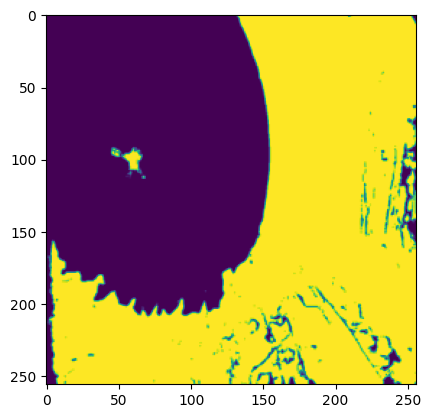

In [11]:
# Plot output frame
plt.imshow(og_image)

tensor(0.5000, device='cuda:0', grad_fn=<MaxBackward1>)

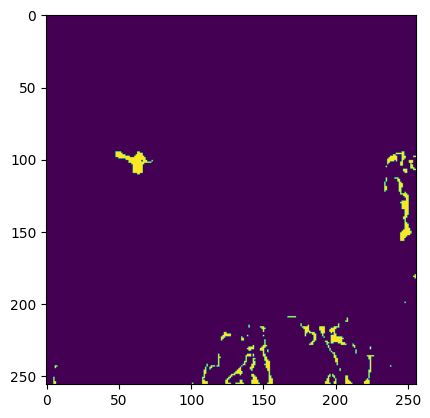

In [13]:
prob_pred_frame = torch.sigmoid(pred_frame)
out = (prob_pred_frame > 0.5).to(torch.float32)
plt.imshow(out[0, 0, 0, :, :].cpu().detach().numpy())
out.max()
prob_pred_frame.max()

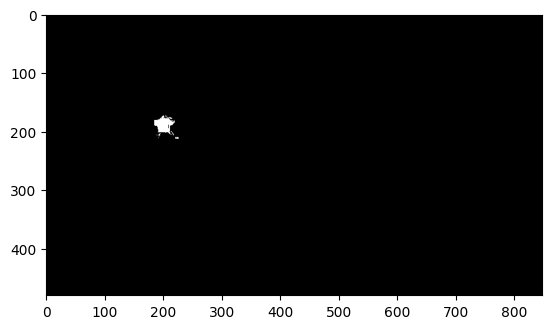

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test3/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

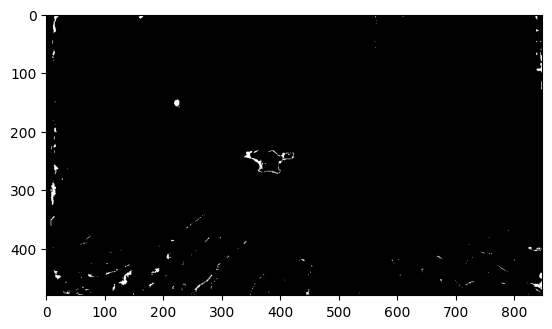

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test1/inputs'
sequence_start = 1500
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

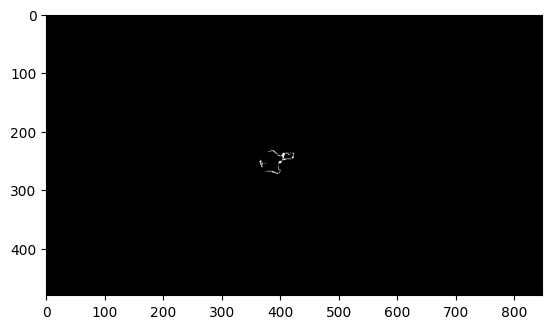

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test1/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

#### Testing dataloader

In [20]:
batch_size = 1
dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=7, seq_length=seq_length, img_size=img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data
counter = 0
for datapoint in loader:
    # found_one = False
    # features = datapoint['input']
    # labels = datapoint['target']
    if counter > 1:
        break
    counter += 1
    # for i in range(batch_size):
    #     image = features[0][i]
    #     if counter > 1502:
    #         found_one = True
    #         break
    #     counter += 1

    # if found_one:
    #     break

# counter
# len(datapoint)
in_frame = datapoint['input'][0][0, -1, 0, :, :]
out_frame = datapoint['target'][0, -1, 0, :, :]
# datapoint['input'][:, 0, :, :, :, 1]
# counter

100%|██████████| 7/7 [00:00<00:00, 169.65it/s]


In [ ]:
# Use transforms to resize images
# This is an example, but it must actually be performed before feeding image data to encoder
# For the augmented tensor the image is already resized inside the dataloader

sequence = next(iter(loader))
if augmented:
    input, target = sequence['input'], sequence['target']
    print(f'Tensor shape should be: [{batch_size, seq_length, 1, img_size, img_size, 14}] and is: {input.shape}')
else:

    features = sequence
    image = features['input'][0]
    input, target = features['input'], features['target']
    print(f'\nBatched image shape should be: [{batch_size, seq_length, 1, img_size, img_size}] and is: {image.shape}')


tensor(1.0000)


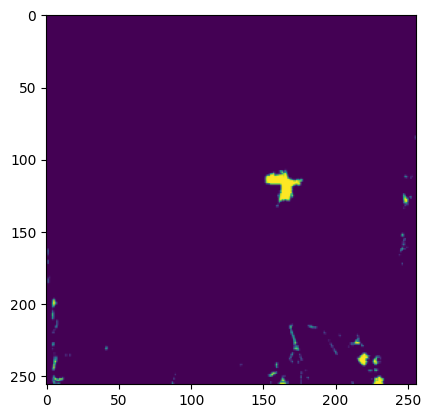

In [ ]:
print(in_frame.max())
plt.imshow(in_frame)

tensor(1.0000)


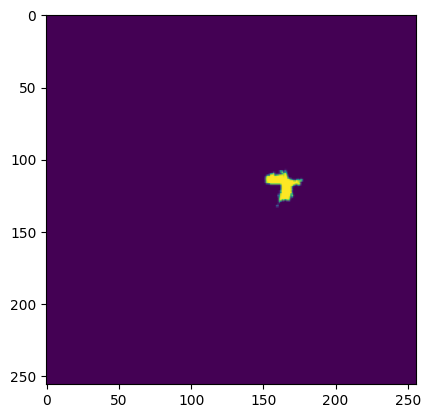

In [ ]:
print(out_frame.max())
plt.imshow(out_frame)

In [ ]:
features[0].shape
counter

1503

In [ ]:
pose = features[1]
pose[28]

tensor([-1.3603,  0.6753,  2.2040,  0.0300,  0.0131,  0.1257,  0.9915])

#### Testing interpolated twist

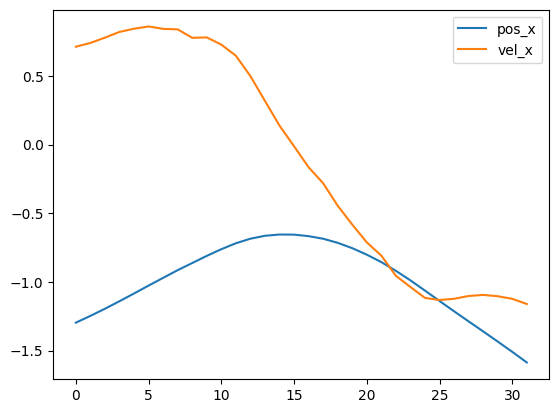

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

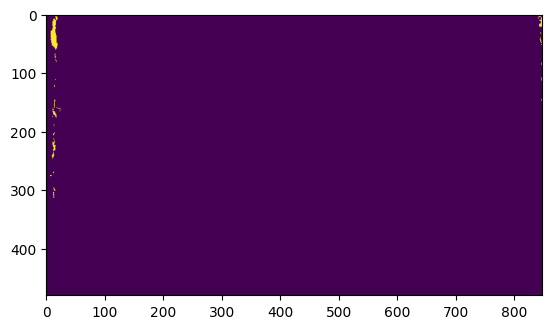

In [ ]:
image = features[0][28]
image.max()
plt.imshow(image)

torch.Size([32, 256, 256])